# DTI Based Tumor Simulation

The input for this solver is a DTI - RGB file and the output is a 3D tumor concentration. 

It was unnecessary to use the full DTI tensors, as we are simulating on a grid. So, I used the diffusion in each direction (x,y,z) within each voxel. This is equivalent to the colored DTI images.
 
This is how you can generate such an RGB image from DTI:  https://docs.dipy.org/stable/user_guide/getting_started.html, but we also included one here.

In [2]:
from TumorGrowthToolkit.FK_DTI import FK_DTI_Solver
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import time
import scipy.ndimage
import nibabel as nib

## Load the provided DTI file.

We use the "RGB" file which is a 4D array.

Dimension 1-3 are the spatial dimensions, and dimension 4 contains the fractional anisotropy (FA) weighted diffusion in x,y,z direction.

shape: (x, y, z, fa-diffusion) : (128, 128, 60, 3)


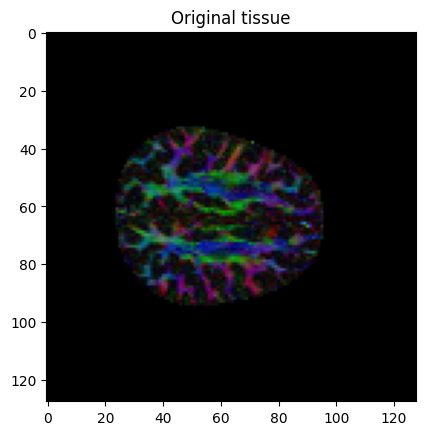

In [4]:
# Apply a Gaussian filter for smooth transitions
tissue = nib.load('dataset/HARDI193_RGB.nii.gz').get_fdata()
print('shape: (x, y, z, fa-diffusion) :', tissue.shape)
plt.imshow(tissue[:,:,40])
plt.title('Original tissue')
plt.show()

## Set the parameters for the simulation

In [8]:
parameters = {
    'Dw': 2.0,          # maximum diffusion coefficient
    'rho': 0.20,        # Proliferation rate
    'rgb':tissue, # diffusion tissue map as shown above
    'diffusionTensorExponent': 3.0, # exponent for the diffusion tensor, 1.0 for linear relationship
    'NxT1_pct': 0.5,    # tumor position [%]
    'NyT1_pct': 0.5,
    'NzT1_pct': 0.626,
    'init_scale': 1., #scale of the initial gaussian
    'resolution_factor': 0.5, #resultion scaling for calculations
    'verbose': True, #printing timesteps 
    'time_series_solution_Nt': 64 # number of timesteps in the output
}

## Run the solver
This might take a few minutes depending on the settings.

In [9]:
# Run the FK_solver and plot the results
start_time = time.time()
fK_DTI_Solver = FK_DTI_Solver(parameters)
result = fK_DTI_Solver.solve()
end_time = time.time()  # Store the end time
execution_time = int(end_time - start_time)  # Calculate the difference

print(f"Execution Time: {execution_time} seconds")
if result['success']:
    print("Simulation successful!")
else:
    print("Error occurred:", result['error'])

Number of simulation timesteps: 500
Execution Time: 2 seconds
Simulation successful!


## Plot the tumor development over time.

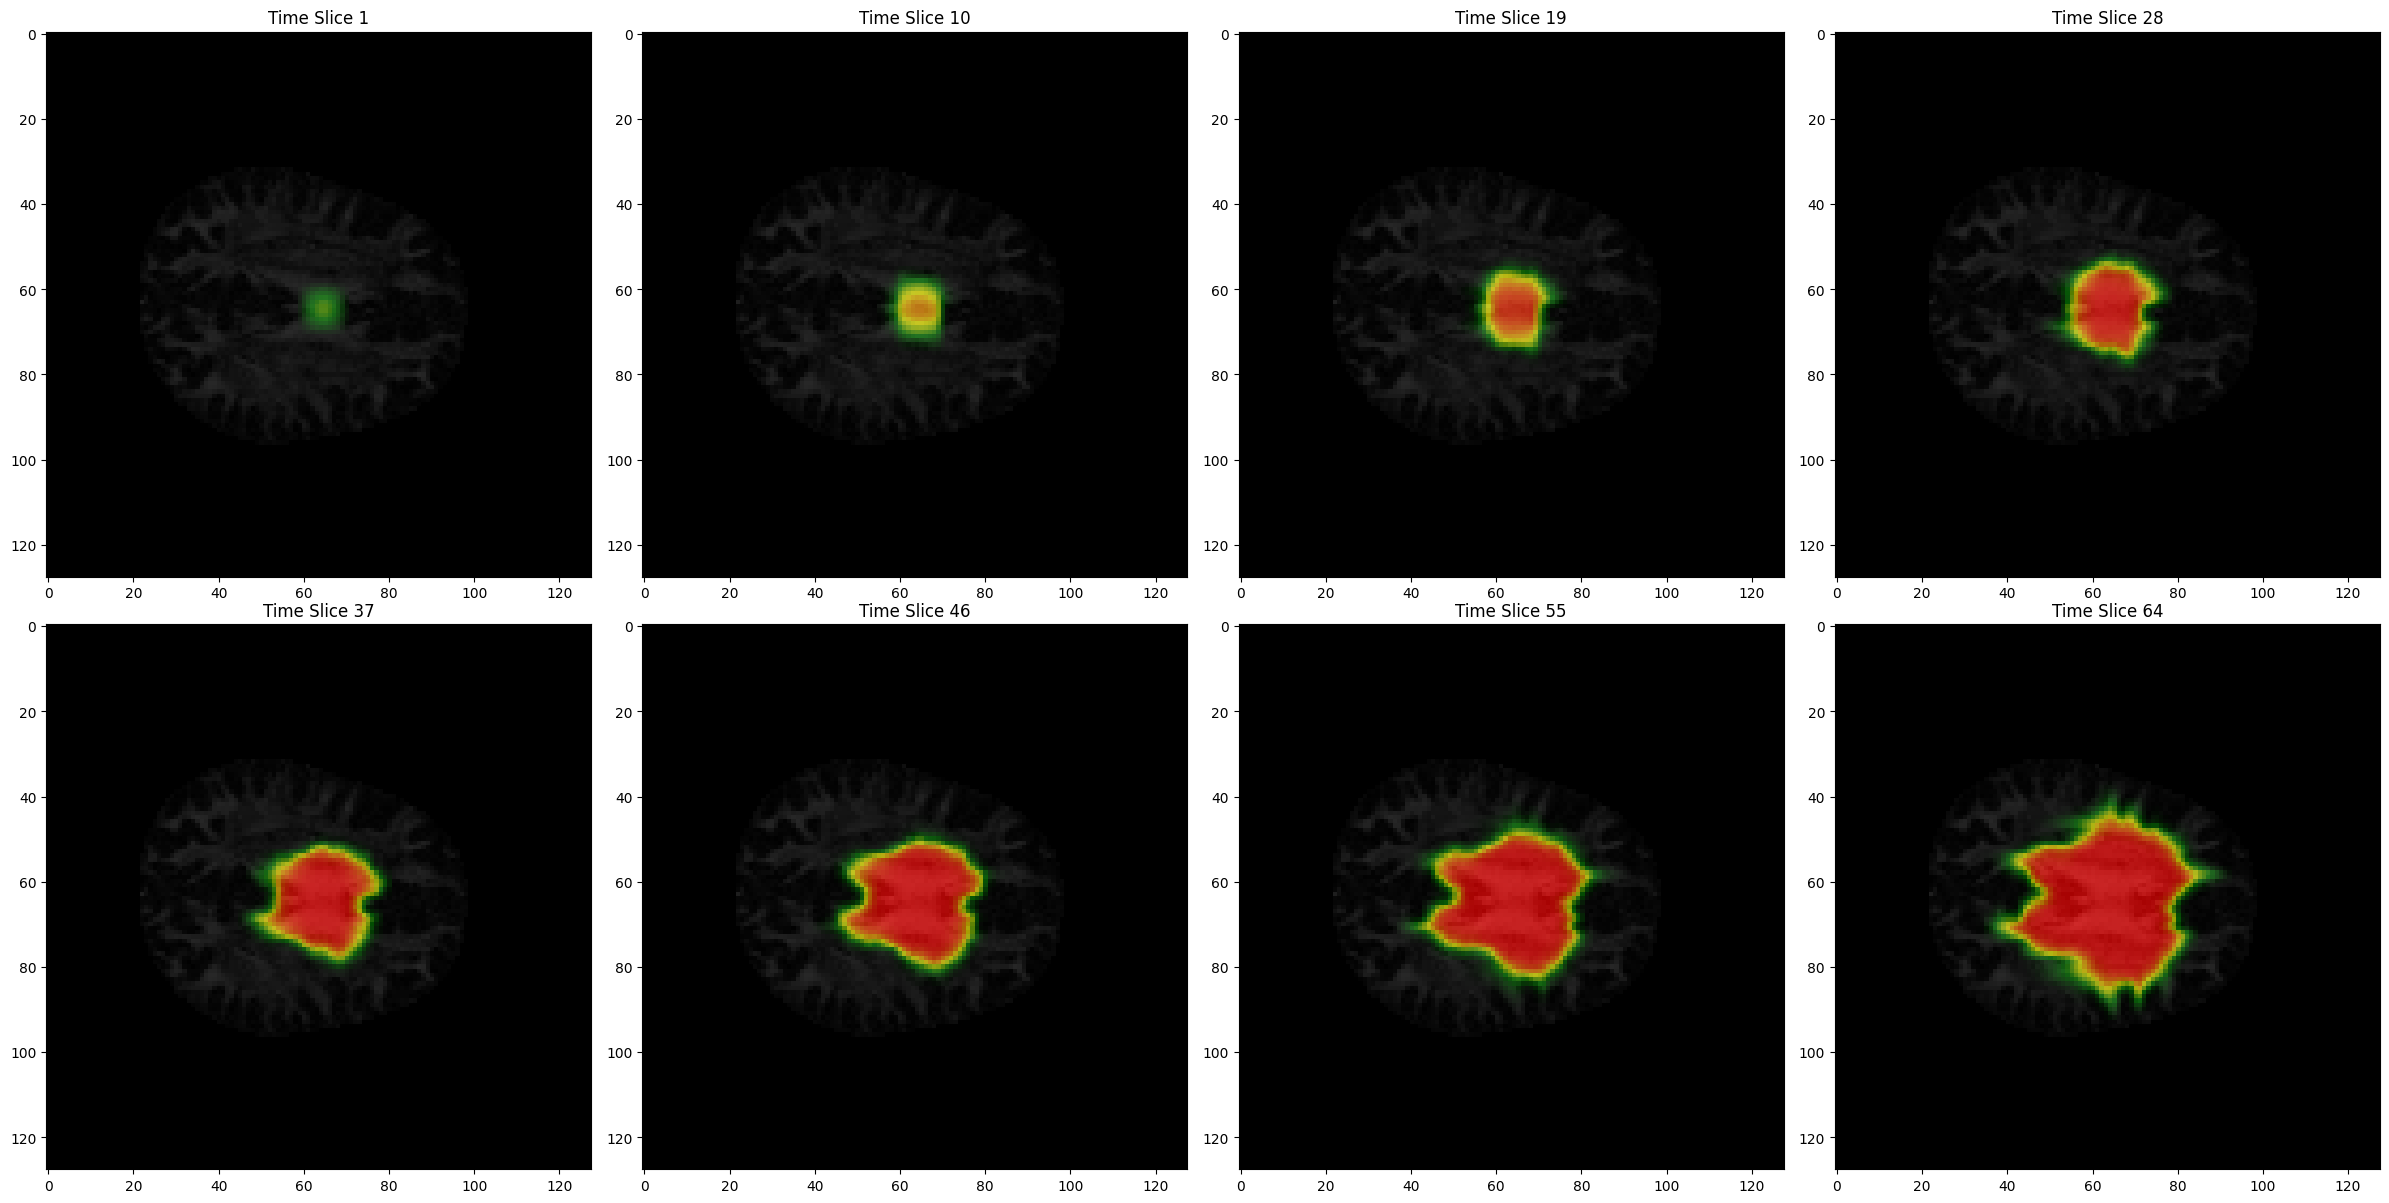

In [10]:
# Create custom color maps
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap', ['black', 'white'], 256)
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap2', ['black', 'green', 'yellow', 'red'], 256)

# Calculate the slice index
NzT = int(parameters['NzT1_pct'] * tissue.shape[2])

def plot_time_series(wm_data, time_series_data, slice_index):
    plt.figure(figsize=(24, 12))

    # Generate 8 indices evenly spaced across the time series length
    time_points = np.linspace(0, time_series_data.shape[0] - 1, 8, dtype=int)

    for i, t in enumerate(time_points):
        plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns, current subplot index
        plt.imshow(wm_data[:, :, slice_index], cmap=cmap1, vmin=0, vmax=1, alpha=1)
        plt.imshow(time_series_data[t, :, :, slice_index], cmap=cmap2, vmin=0, vmax=1, alpha=0.65)
        plt.title(f"Time Slice {t + 1}")

    plt.tight_layout()
    plt.show()

plot_time_series(np.mean(tissue, axis=3),result['time_series'], NzT)
